### This notebook clusters the beached points with the HDBSCAN clustering method from scikit-learn
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
pip install hdbscan

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

from sklearn.preprocessing import MinMaxScaler
import hdbscan

In [4]:
# import undrogued data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

In [100]:
beach['speed'] = np.sqrt(beach['ve']**2 + beach['vn']**2)

In [5]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering

# input feature: average velocity of trajectory
#v_avg_data = np.array(beach.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
#v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
#v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
#first_points_input = beach.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

#time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
#time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
#time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

In [6]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size = 20, # minimum number beach points in a cluster
    cluster_selection_epsilon = 6.5) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

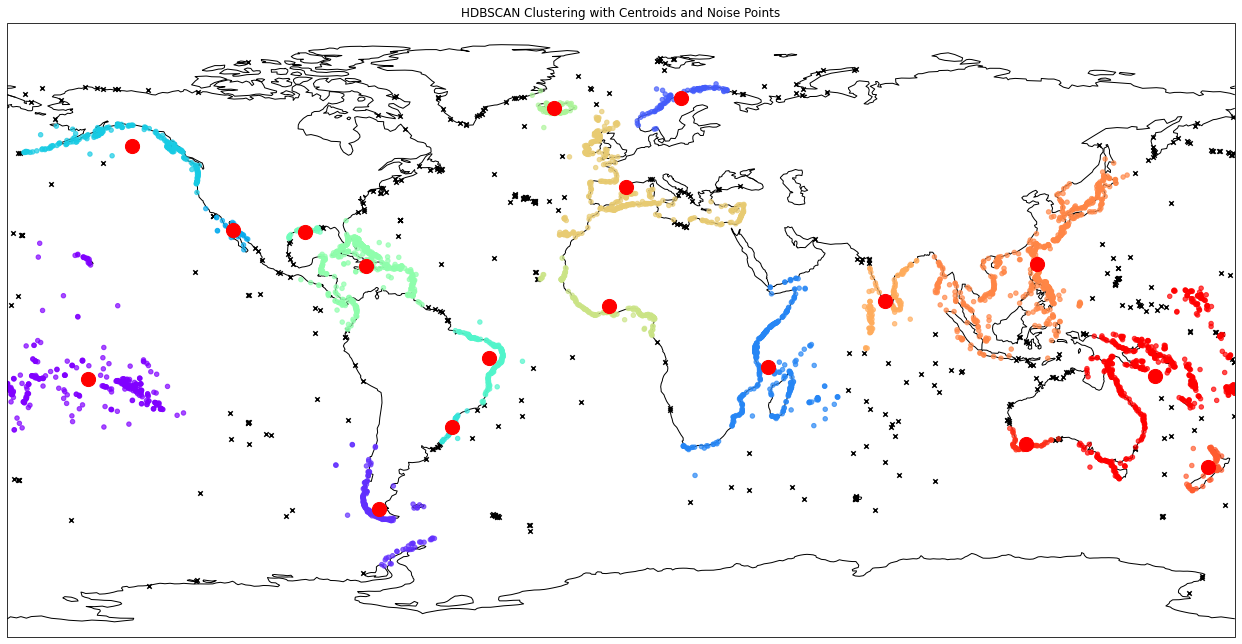

In [88]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')


# Plot points
scatter = ax.scatter(cluster_input[labels != -1, 1], cluster_input[labels != -1, 0], c=labels[labels != -1], cmap='rainbow', alpha=0.7, s=20)

# Plot centroids
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        ax.scatter(centroid[1], centroid[0], marker='o', color='red', s=200, label=f'Cluster {cluster_id} Centroid')


#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [82]:
# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 100:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/3)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

In [89]:
beach_clusters

id        time       lat        lon      ve      vn  \
22456                4888  1034985600  39.46599  131.21625 -0.0216 -0.2384   
22457                4888  1034989200  39.45887  131.21461 -0.0258 -0.2333   
22458                4888  1034992800  39.45132  131.21230 -0.0316 -0.2327   
22459                4888  1034996400  39.44287  131.18474 -0.1830 -0.2366   
22460                4888  1035000000  39.44128  131.17710 -0.1951 -0.1807   
...                   ...         ...       ...        ...     ...     ...   
23025523  300234067207250  1586127600  -9.20731  -28.87556 -0.1192  0.0527   
23025524  300234067207250  1586131200  -9.20529  -28.87980 -0.1386  0.0809   
23025525  300234067207250  1586134800  -9.20306  -28.88474 -0.1637  0.0575   
23025526  300234067207250  1586138400  -9.20178  -28.89015 -0.1668  0.0156   
23025527  300234067207250  1586142000  -9.20180  -28.89551 -0.1607 -0.0123   

          time_to_beach  HDBSCAN  
22456         3376800.0     14.0  
22457         3373200.0     14.0  
22458         3369600.0     14.0  
22459         3366000.0     14.0  
22460         3362400.0     14.0  
...                 ...      ...  
23025523        14400.0      7.0  
23025524        10800.0      7.0  
23025525         7200.0      7.0  
23025526         3600.0      7.0  
23025527            0.0      7.0  

[3522391 rows x 8 columns]

### let's plot the trajectories of these clusters

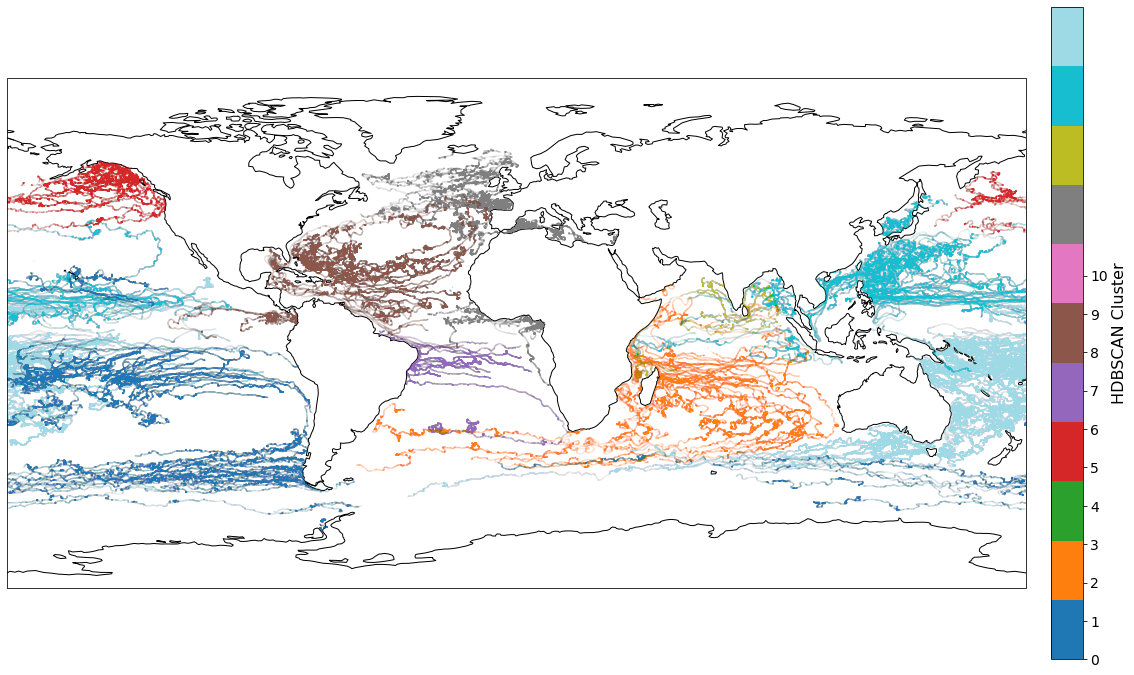

In [83]:
num_clusters_HDSBSCAN = len(np.unique(beach_clusters['HDBSCAN']))

# Create a colormap with distinct colors for each cluster
colors_HDBSCAN = plt.cm.get_cmap('tab20', num_clusters_HDSBSCAN)

point_size = 0.00005


# Plotting code
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

#first_cluster_df = beach_clusters[beach_clusters['HDBSCAN'] == 1]

# Scatter plot with colors based on HDBSCAN labels
plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['HDBSCAN'],
    cmap=colors_HDBSCAN,
    s=point_size
)



# Add colorbar
cbar = plt.colorbar(orientation='vertical', pad=0.02, ticks=np.arange(num_clusters_HDSBSCAN))
cbar.set_label('HDBSCAN Cluster', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

In [ ]:
#first_cluster_df = beach_clusters[beach_clusters['HDBSCAN'] == 1]

### CLUSTER COMPARISON (LAT/LON, TIME, AVG V)

In [209]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering AND RUN HDBSCAN TWICE

# input feature: average velocity of trajectory
#v_avg_data = np.array(beach.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
#v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
#v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
#first_points_input = beach.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

#time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
#time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
#time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 30, # minimum number beach points in a cluster
    cluster_selection_epsilon = 6) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

#organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 100:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), beach_clusters_select.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(beach_clusters_select['id'])]

In [210]:
# NOW INPUT CLUSTERED DATA INTO NEW HDBSCAN

# input feature: average velocity of trajectory
#v_avg_data = np.array(beach_clusters.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
#v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
#v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
#first_points_input = beach_clusters.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

#time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
#time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
#time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach_clusters.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 20, # minimum number beach points in a cluster
    cluster_selection_epsilon = 5) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

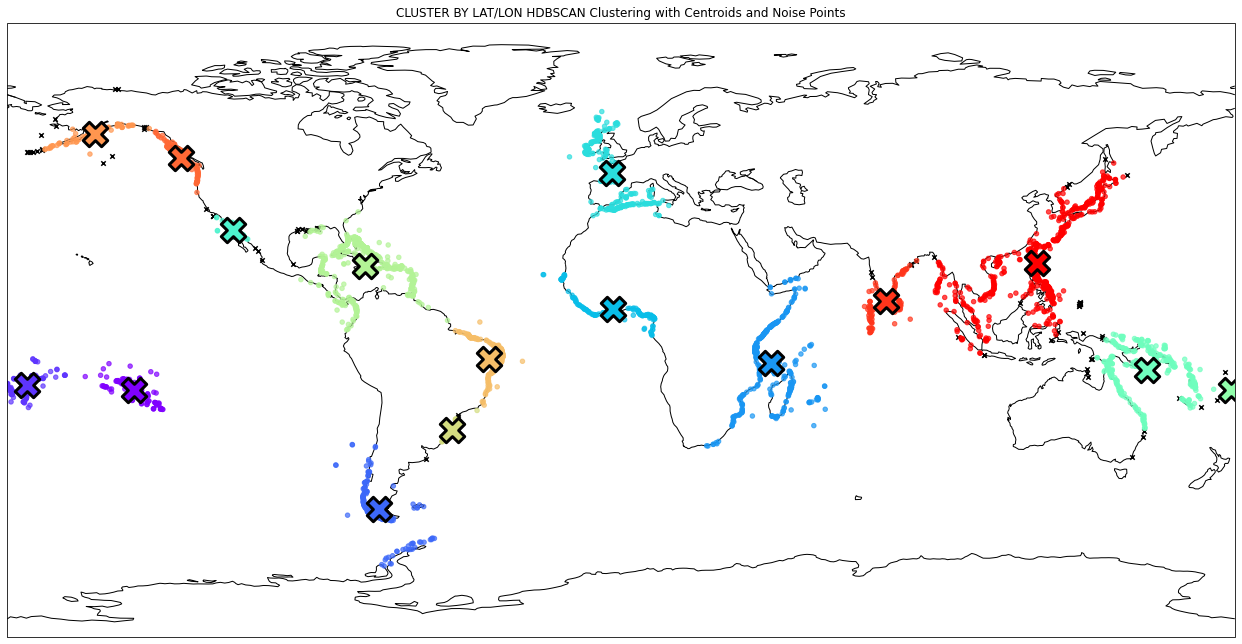

In [211]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
scatter1 = plt.scatter(
    cluster_input[labels != -1, 1],
    cluster_input[labels != -1, 0],
    marker='o',
    c=labels[labels != -1],
    cmap='rainbow',
    alpha=0.7,
    s=20
)

# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')

# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CLUSTER BY LAT/LON HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [213]:
# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 75:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/6)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

# Create a colormap with distinct colors for each cluster label
colors_custom_cmap = plt.cm.get_cmap('rainbow', len(unique_labels_figure1))

# Create a dictionary to map each cluster label to its corresponding color
cluster_color_mapping = dict(zip(unique_labels_figure1, range(len(unique_labels_figure1))))

# Apply the mapping to the HDBSCAN labels in the beach_clusters DataFrame
beach_clusters['Color'] = beach_clusters['HDBSCAN'].map(cluster_color_mapping)

(array([354563., 141947., 350676., 129742., 447935.,      0., 433403.,
        204706.,  53006., 520634.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

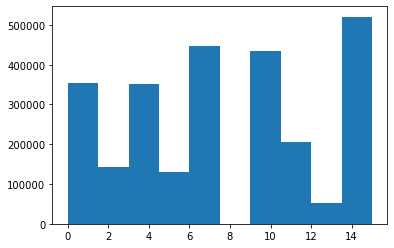

In [214]:
plt.hist(beach_clusters['HDBSCAN'])

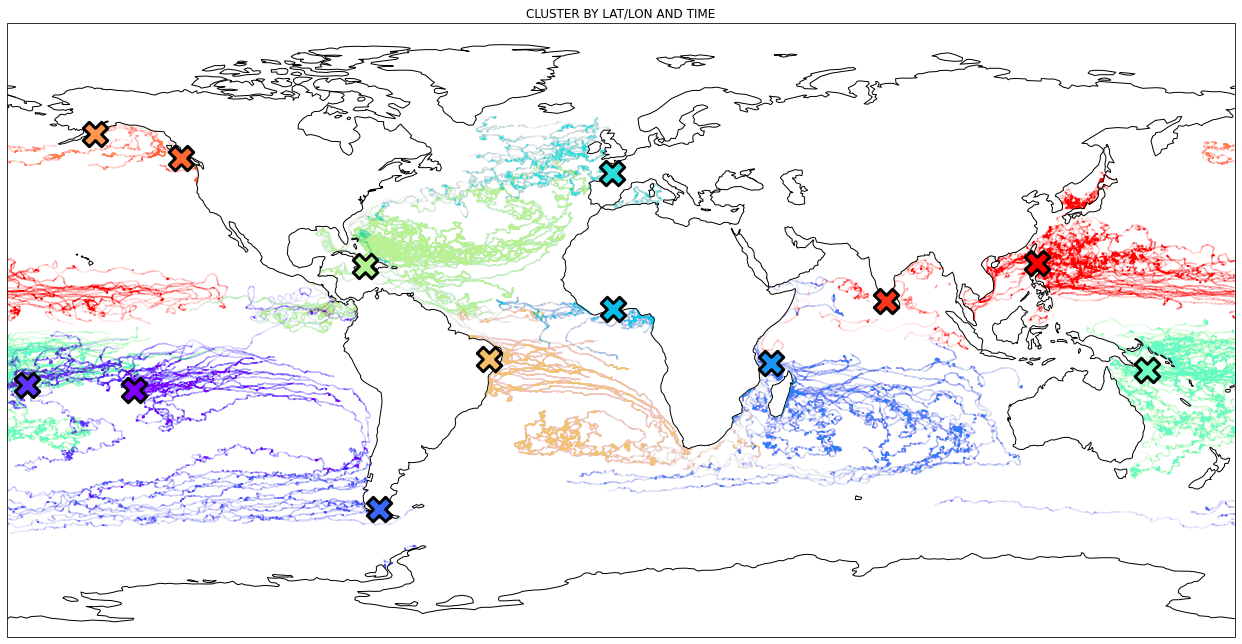

In [220]:
# Plotting code for the second figure

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['Color'],
    cmap=colors_custom_cmap,
    s=point_size,
    alpha=0.7
)


# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id in np.unique(beach_clusters['HDBSCAN']):
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')


# Add colorbar
#cbar = plt.colorbar(scatter2, orientation='vertical', pad=0.02, ticks=unique_labels_figure2)
#cbar.set_label('HDBSCAN Cluster', fontsize=16)
#cbar.ax.tick_params(labelsize=14)

plt.title('CLUSTER BY LAT/LON AND TIME')

plt.show()

# ----------

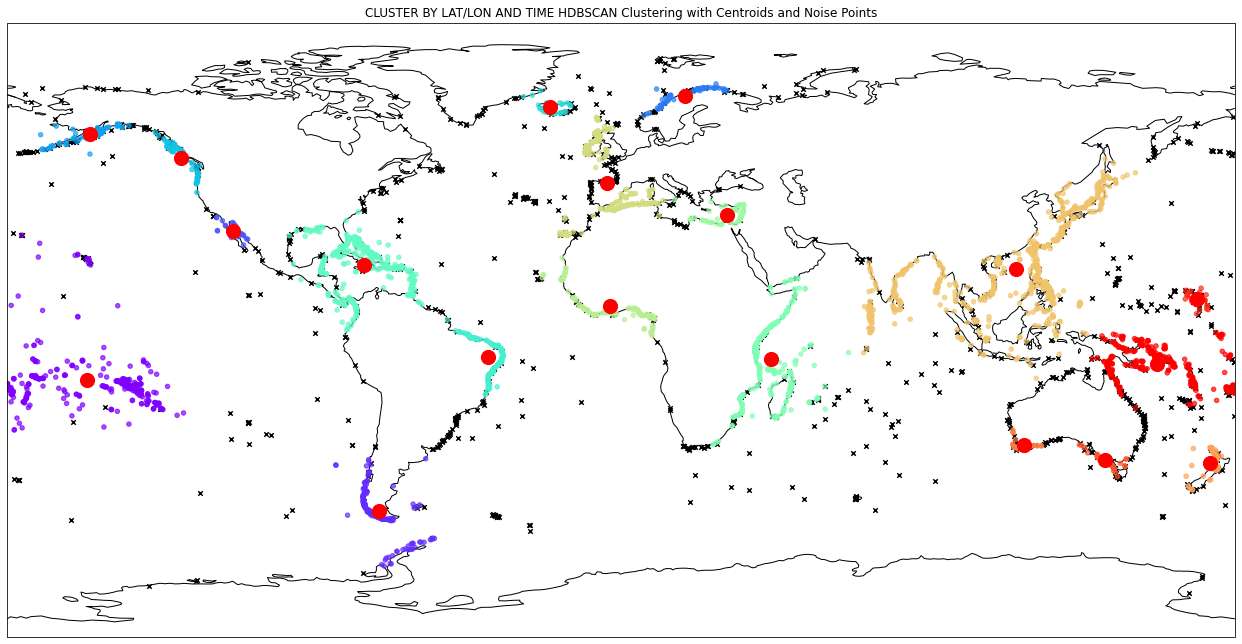

In [96]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering

# input feature: average velocity of trajectory
#v_avg_data = np.array(beach.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
#v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
#v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
first_points_input = beach.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon, time_normalized))#, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 20, # minimum number beach points in a cluster
    cluster_selection_epsilon = 6.5) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')


# Plot points
scatter = ax.scatter(cluster_input[labels != -1, 1], cluster_input[labels != -1, 0], c=labels[labels != -1], cmap='rainbow', alpha=0.7, s=20)

# Plot centroids
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        ax.scatter(centroid[1], centroid[0], marker='o', color='red', s=200, label=f'Cluster {cluster_id} Centroid')


#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CLUSTER BY LAT/LON AND TIME HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [ ]:
# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 100:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/3)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

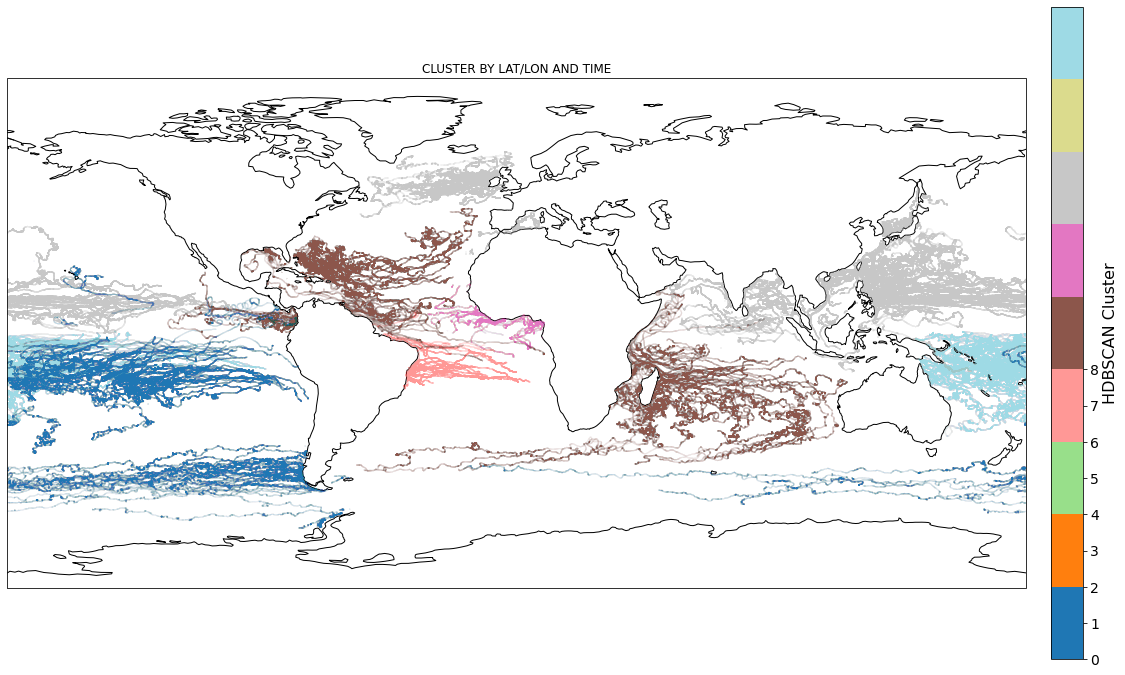

In [97]:
# Plotting code
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

point_size = 0.00005



# Scatter plot with colors based on HDBSCAN labels
plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['HDBSCAN'],
    cmap=colors_HDBSCAN,
    s=point_size
)



# Add colorbar
cbar = plt.colorbar(orientation='vertical', pad=0.02, ticks=np.arange(num_clusters_HDSBSCAN))
cbar.set_label('HDBSCAN Cluster', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.title('CLUSTER BY LAT/LON AND TIME')

plt.show()

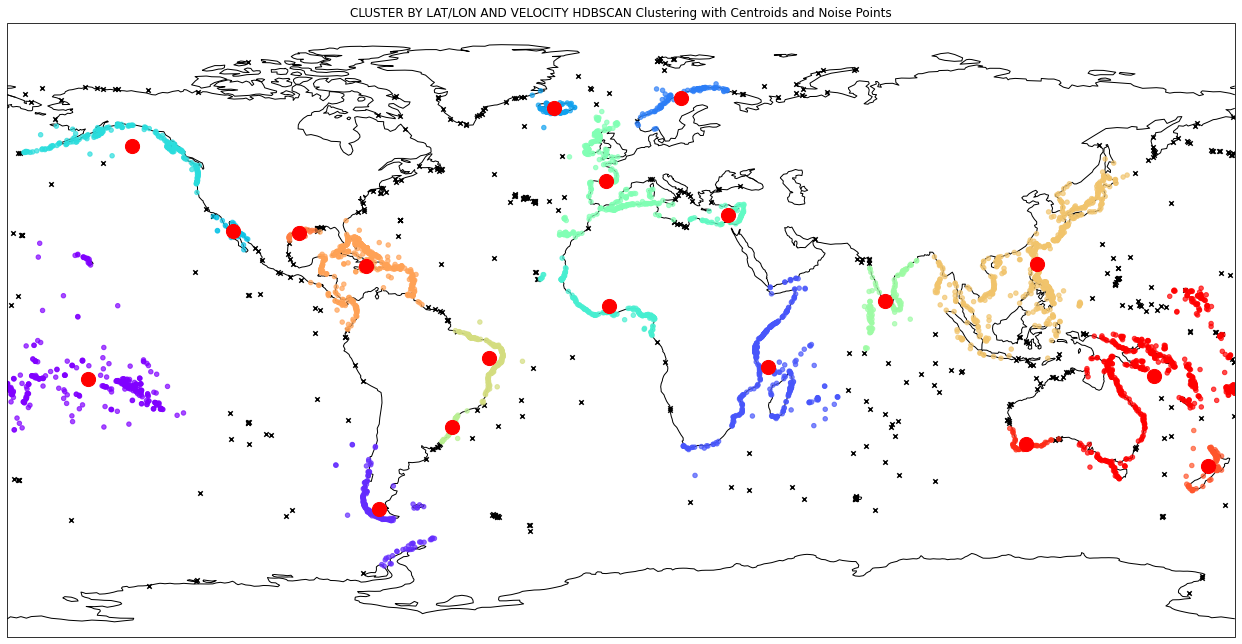

In [102]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering

# input feature: average velocity of trajectory
v_avg_data = np.array(beach.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
#first_points_input = beach.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

#time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
#time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
#time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon, v_avg_normalized))#, time_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 20, # minimum number beach points in a cluster
    cluster_selection_epsilon = 6.5) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')


# Plot points
scatter = ax.scatter(cluster_input[labels != -1, 1], cluster_input[labels != -1, 0], c=labels[labels != -1], cmap='rainbow', alpha=0.7, s=20)

# Plot centroids
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        ax.scatter(centroid[1], centroid[0], marker='o', color='red', s=200, label=f'Cluster {cluster_id} Centroid')


#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CLUSTER BY LAT/LON AND VELOCITY HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

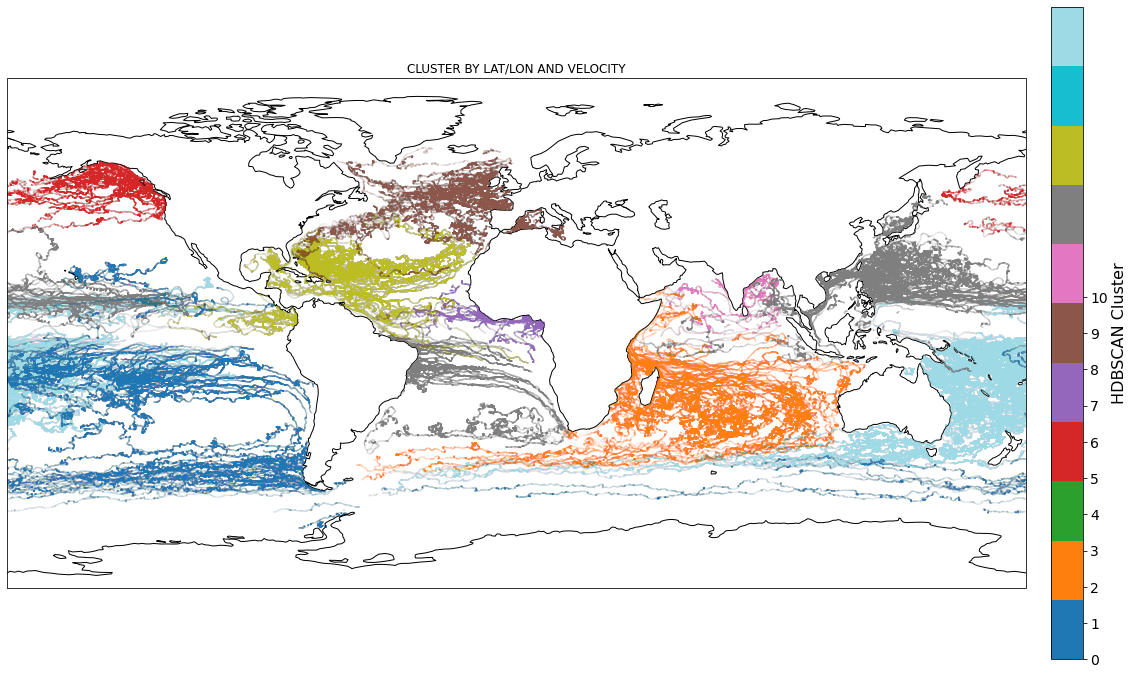

In [103]:
# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 100:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/3)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

num_clusters_HDSBSCAN = len(np.unique(beach_clusters['HDBSCAN']))

# Create a colormap with distinct colors for each cluster
colors_HDBSCAN = plt.cm.get_cmap('tab20', num_clusters_HDSBSCAN)

point_size = 0.00005


# Plotting code
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

#first_cluster_df = beach_clusters[beach_clusters['HDBSCAN'] == 1]

# Scatter plot with colors based on HDBSCAN labels
plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['HDBSCAN'],
    cmap=colors_HDBSCAN,
    s=point_size
)



# Add colorbar
cbar = plt.colorbar(orientation='vertical', pad=0.02, ticks=np.arange(num_clusters_HDSBSCAN))
cbar.set_label('HDBSCAN Cluster', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.title('CLUSTER BY LAT/LON AND VELOCITY')

plt.show()

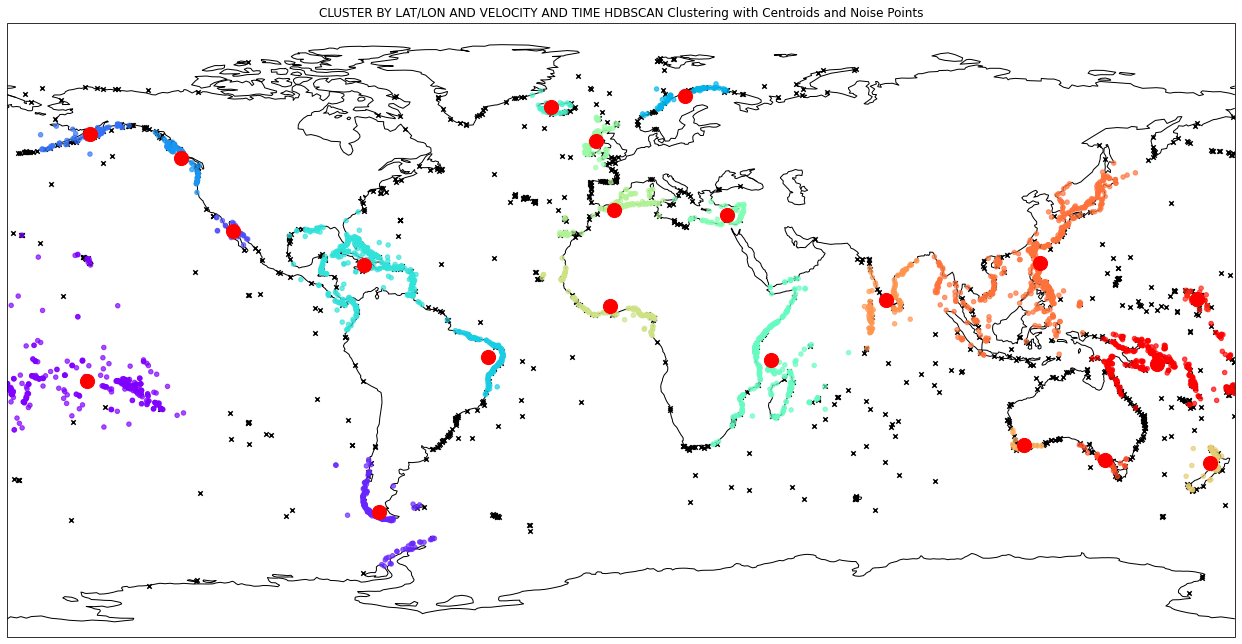

In [105]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering

# input feature: average velocity of trajectory
v_avg_data = np.array(beach.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
first_points_input = beach.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon, v_avg_normalized, time_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 20, # minimum number beach points in a cluster
    cluster_selection_epsilon = 6.5) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')


# Plot points
scatter = ax.scatter(cluster_input[labels != -1, 1], cluster_input[labels != -1, 0], c=labels[labels != -1], cmap='rainbow', alpha=0.7, s=20)

# Plot centroids
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        ax.scatter(centroid[1], centroid[0], marker='o', color='red', s=200, label=f'Cluster {cluster_id} Centroid')


#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CLUSTER BY LAT/LON AND VELOCITY AND TIME HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

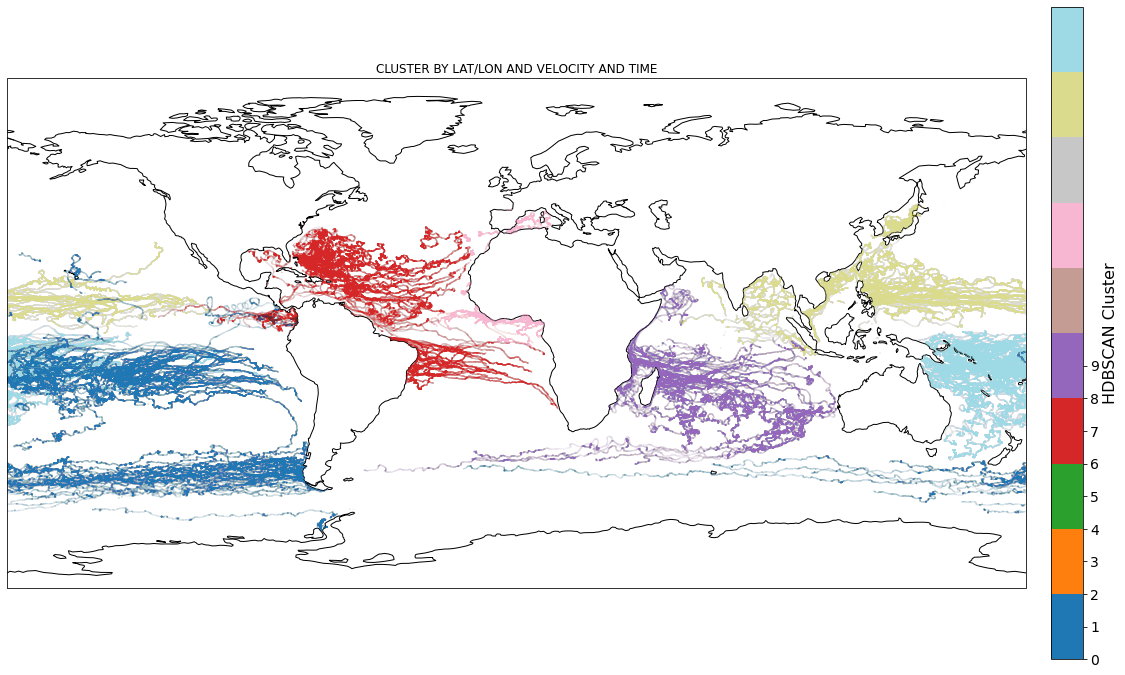

In [106]:
# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 100:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/3)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

num_clusters_HDSBSCAN = len(np.unique(beach_clusters['HDBSCAN']))

# Create a colormap with distinct colors for each cluster
colors_HDBSCAN = plt.cm.get_cmap('tab20', num_clusters_HDSBSCAN)

point_size = 0.00005


# Plotting code
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

#first_cluster_df = beach_clusters[beach_clusters['HDBSCAN'] == 1]

# Scatter plot with colors based on HDBSCAN labels
plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['HDBSCAN'],
    cmap=colors_HDBSCAN,
    s=point_size
)



# Add colorbar
cbar = plt.colorbar(orientation='vertical', pad=0.02, ticks=np.arange(num_clusters_HDSBSCAN))
cbar.set_label('HDBSCAN Cluster', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.title('CLUSTER BY LAT/LON AND VELOCITY AND TIME')

plt.show()